In [1521]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [1522]:
decision = pd.read_csv(r'dados_ciclo_basic\decision.csv.csv')
results = pd.read_csv(r'dados_ciclo_basic\FIFA Results.csv')
penal = pd.read_csv(r'dados_ciclo_basic\penality kick.csv.csv')
rank = pd.read_csv(r'dados_ciclo_basic\Fifa_ranking_2022-10-06.csv')
dados_copa = pd.read_csv(r'dados_ciclo_basic\world_cup.csv')
match_results = pd.read_csv(r'dados_ciclo_basic\matches_1930_2022.csv')

In [1523]:
match_results = match_results.rename(columns={'Date': 'date'})

match_results['date'] = pd.to_datetime(match_results['date'])
decision['date'] = pd.to_datetime(decision['date'])

merged_df = pd.merge(
    match_results,
    decision,
    on=['date', 'home_team', 'away_team', 'home_score', 'away_score'],
    how='left'  
)

In [1524]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['year'] = merged_df['date'].dt.year

home_df = merged_df[[
    'home_team', 'away_team', 'home_score', 'away_score',
    'home_xg', 'away_xg', 'year'
]].copy()
home_df.columns = ['team', 'opponent', 'goals_for', 'goals_against', 'xg_for', 'xg_against', 'year']

away_df = merged_df[[
    'away_team', 'home_team', 'away_score', 'home_score',
    'away_xg', 'home_xg', 'year'
]].copy()
away_df.columns = ['team', 'opponent', 'goals_for', 'goals_against', 'xg_for', 'xg_against', 'year']

long_df = pd.concat([home_df, away_df], ignore_index=True)

team_stats = long_df.groupby(['team', 'year']).agg({
    'goals_for': 'sum',
    'goals_against': 'sum',
    'xg_for': 'sum',
    'xg_against': 'sum',
    'opponent': 'count'  # número de jogos
}).rename(columns={'opponent': 'matches'}).reset_index()


In [1525]:
match_results = match_results.rename(columns={'Year': 'year'})

In [1526]:
home_results = match_results[['home_team', 'home_score', 'away_score', 'year']].copy()
home_results.rename(columns={'home_team':'team', 'home_score':'goals_for', 'away_score':'goals_against'}, inplace=True)

away_results = match_results[['away_team', 'away_score', 'home_score', 'year']].copy()
away_results.rename(columns={'away_team':'team', 'away_score':'goals_for', 'home_score':'goals_against'}, inplace=True)

all_results = pd.concat([home_results, away_results], ignore_index=True)

def get_result(row):
    if row['goals_for'] > row['goals_against']:
        return 'win'
    elif row['goals_for'] == row['goals_against']:
        return 'draw'
    else:
        return 'loss'

all_results['result'] = all_results.apply(get_result, axis=1)

stats = all_results.groupby(['team', 'year'])['result'].value_counts().unstack(fill_value=0)

stats['matches'] = stats.sum(axis=1)
stats['win_rate'] = stats['win'] / stats['matches']

print(stats.head())

team_stats = team_stats.merge(stats[['matches', 'win', 'draw', 'loss','win_rate']], on=['team', 'year'], how='left')


result        draw  loss  win  matches  win_rate
team    year                                    
Algeria 1982     0     1    2        3  0.666667
        1986     1     2    0        3  0.000000
        2010     1     2    0        3  0.000000
        2014     1     2    1        4  0.250000
Angola  2006     2     1    0        3  0.000000


In [1527]:
team_stats = team_stats.merge(
    dados_copa[['Year', 'Champion']],
    left_on='year',
    right_on='Year',
    how='left'
)

team_stats['champion'] = (team_stats['team'] == team_stats['Champion']).astype(int)

team_stats.drop(columns=['Champion', 'Year'], inplace=True)

team_stats.head()

,team,year,goals_for,goals_against,xg_for,xg_against,matches_x,matches_y,win,draw,loss,win_rate,champion
0,Algeria,1982,5,5,0.0,0.0,3,3,2,0,1,0.666667,0
1,Algeria,1986,1,5,0.0,0.0,3,3,0,1,2,0.000000,0
2,Algeria,2010,0,2,0.0,0.0,3,3,0,1,2,0.000000,0
3,Algeria,2014,7,7,0.0,0.0,4,4,1,1,2,0.250000,0
4,Angola,2006,1,2,0.0,0.0,3,3,0,2,1,0.000000,0


In [1528]:
team_stats = team_stats.merge(
    dados_copa[['Year', 'Host']],
    left_on='year',
    right_on='Year',
    how='left'
)
team_stats.drop(columns='Year', inplace=True)

print(team_stats[['team', 'year', 'Host']].drop_duplicates().sort_values('year'))

              team  year     Host
5        Argentina  1930  Uruguay
50         Bolivia  1930  Uruguay
444  United States  1930  Uruguay
54          Brazil  1930  Uruguay
93           Chile  1930  Uruguay
..             ...   ...      ...
439        Tunisia  2022    Qatar
28       Australia  2022    Qatar
454  United States  2022    Qatar
468        Uruguay  2022    Qatar
22       Argentina  2022    Qatar

[489 rows x 3 columns]


In [1529]:
team_stats['matches'] = team_stats['matches_y']

team_stats.drop(columns=['matches_x', 'matches_y'], inplace=True)

In [1530]:
decision['date'] = pd.to_datetime(decision['date'])
decision['year'] = decision['date'].dt.year

home_d = decision[['home_team', 'away_team', 'tournament', 'city', 'country', 'neutral', 'year']].copy()
home_d.columns = ['team', 'opponent', 'tournament', 'city', 'country', 'neutral', 'year']

away_d = decision[['away_team', 'home_team', 'tournament', 'city', 'country', 'neutral', 'year']].copy()
away_d.columns = ['team', 'opponent', 'tournament', 'city', 'country', 'neutral', 'year']

decision_long = pd.concat([home_d, away_d], ignore_index=True)

decision_agg = decision_long.groupby(['team', 'year']).agg({
    'neutral': 'mean',         # % de jogos em campo neutro
    'tournament': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'country': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
}).reset_index()

decision_agg.rename(columns={'neutral': 'pct_neutral_games'}, inplace=True)

In [1531]:
team_stats['goal_difference'] = team_stats['goals_for'] - team_stats['goals_against']
team_stats['avg_goals_for'] = team_stats['goals_for'] / team_stats['matches']
team_stats['avg_goals_against'] = team_stats['goals_against'] / team_stats['matches']
team_stats['goal_ratio'] = team_stats['goals_for'] / (team_stats['goals_against'] + 1e-5)
team_stats['xg_difference'] = team_stats['xg_for'] - team_stats['xg_against']
team_stats['avg_xg_for'] = team_stats['xg_for'] / team_stats['matches']

In [1532]:
team_stats = team_stats.merge(
    decision_agg,
    on=['team', 'year'],
    how='left'
)

In [1533]:
team_stats = team_stats.merge(
    rank[['team', 'rank', 'points']],
    on='team',
    how='left'
)

In [1534]:
team_stats = team_stats.drop(columns=['country'])

In [1535]:
team_stats = team_stats[
    team_stats['tournament'].isin(['FIFA World Cup qualification', 'FIFA World Cup', ])
].copy()
team_stats['is_host'] = (team_stats['team'] == team_stats['Host']).astype(int)


worldcup_2022_teams = pd.concat([
    decision[(decision['year'] == 2022) & (decision['tournament'].str.contains("World Cup", case=False))]['home_team'],
    decision[(decision['year'] == 2022) & (decision['tournament'].str.contains("World Cup", case=False))]['away_team']
]).unique()

team_stats = team_stats[team_stats['team'].isin(worldcup_2022_teams)]

In [1536]:
team_stats.head()

,team,year,goals_for,goals_against,xg_for,xg_against,win,draw,loss,win_rate,...,avg_goals_for,avg_goals_against,goal_ratio,xg_difference,avg_xg_for,pct_neutral_games,tournament,rank,points,is_host
5,Argentina,1930,18,9,0.0,0.0,4,0,1,0.800000,...,3.600000,1.800000,1.999998,0.0,0.0,0.571429,FIFA World Cup,3.0,1773.88,0
8,Argentina,1962,2,3,0.0,0.0,1,1,1,0.333333,...,0.666667,1.000000,0.666664,0.0,0.0,0.375000,FIFA World Cup,3.0,1773.88,0
9,Argentina,1966,4,2,0.0,0.0,2,1,1,0.500000,...,1.000000,0.500000,1.999990,0.0,0.0,0.500000,FIFA World Cup,3.0,1773.88,0
10,Argentina,1974,9,12,0.0,0.0,1,2,3,0.166667,...,1.500000,2.000000,0.749999,0.0,0.0,0.461538,FIFA World Cup,3.0,1773.88,0
11,Argentina,1978,15,4,0.0,0.0,5,1,1,0.714286,...,2.142857,0.571429,3.749991,0.0,0.0,0.000000,FIFA World Cup,3.0,1773.88,1


In [1537]:
features = [
    'goals_for', 'goals_against', 'win', 'draw', 'loss', 'win_rate',
    'goal_difference', 'avg_goals_for', 'avg_goals_against', 'goal_ratio', 'rank', 'points', 
]

In [1538]:
team_stats.columns

Index(['team', 'year', 'goals_for', 'goals_against', 'xg_for', 'xg_against',
       'win', 'draw', 'loss', 'win_rate', 'champion', 'Host', 'matches',
       'goal_difference', 'avg_goals_for', 'avg_goals_against', 'goal_ratio',
       'xg_difference', 'avg_xg_for', 'pct_neutral_games', 'tournament',
       'rank', 'points', 'is_host'],
      dtype='object')

In [1539]:
team_stats.drop(columns=['xg_for', 'xg_against', 'xg_difference','avg_xg_for','is_host', 'pct_neutral_games', 'tournament', 'is_host', 'matches', 'Host'], inplace=True)

=== Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        34
           1       0.67      0.80      0.73         5

    accuracy                           0.92        39
   macro avg       0.82      0.87      0.84        39
weighted avg       0.93      0.92      0.93        39


=== Importância das Features ===
loss                 0.239432
goal_difference      0.190937
win                  0.162023
win_rate             0.113022
goal_ratio           0.098535
goals_for            0.073050
avg_goals_for        0.033330
avg_goals_against    0.023186
points               0.020454
draw                 0.017853
rank                 0.014807
goals_against        0.013371
dtype: float64


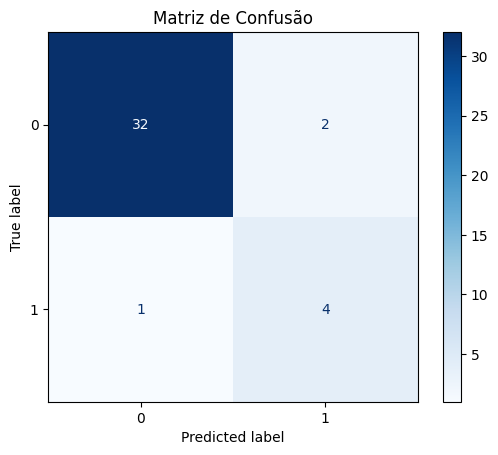

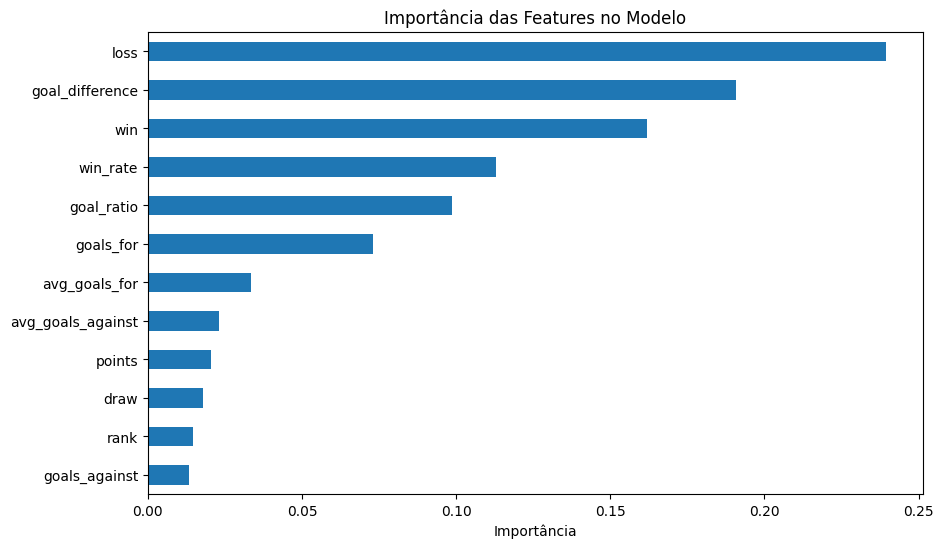

In [1540]:
for col in features:
    median = team_stats[col].median()
    team_stats[col] = team_stats[col].fillna(median)

team_stats = team_stats.dropna(subset=['champion'])


X = team_stats[features]
y = team_stats['champion']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Padronização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Treinamento do modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test_scaled)
print("=== Relatório de Classificação (Teste) ===")
print(classification_report(y_test, y_pred))

importances = model.feature_importances_
importance_series = pd.Series(importances, index=features).sort_values(ascending=False)
print("\n=== Importância das Features ===")
print(importance_series)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)  
plt.title("Matriz de Confusão")
plt.show()

plt.figure(figsize=(10, 6))
importance_series.plot(kind='barh')
plt.xlabel("Importância")
plt.title("Importância das Features no Modelo")
plt.gca().invert_yaxis() 
plt.show()


In [1541]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
from bs4 import BeautifulSoup
import time

# 1. Configurar Selenium (headless)
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
driver = webdriver.Chrome(options=options)

# 2. Acessar a página
url = "https://ge.globo.com/futebol/copa-do-mundo/eliminatorias-america-do-sul/"
driver.get(url)

# 3. Esperar carregar
time.sleep(5)

# 4. Pegar o HTML renderizado
html = driver.page_source
driver.quit()

# 5. Parsear com BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

# 6. Coletar os nomes dos times
teams_table = soup.find('table', class_='tabela__equipes')
team_names = [row.find('strong').text for row in teams_table.find_all('tr') if row.find('strong')]

# 7. Coletar estatísticas da outra tabela
stats_table = soup.find_all('table', class_='tabela__pontos')[0]
stats_rows = stats_table.find_all('tr')[1:]  # pula cabeçalho

data = []
for i, row in enumerate(stats_rows):
    cols = row.find_all('td')
    if len(cols) >= 9:
        data.append({
            'team': team_names[i],
            'points': int(cols[0].text),
            'played': int(cols[1].text),
            'wins': int(cols[2].text),
            'draws': int(cols[3].text),
            'losses': int(cols[4].text),
            'goals_for': int(cols[5].text),
            'goals_against': int(cols[6].text),
            'goal_difference': int(cols[7].text),
            'percentage': int(cols[8].text)
        })

# 8. Criar DataFrame
df_conmebol = pd.DataFrame(data)
df_conmebol["win_rate"] = df_conmebol["wins"] / df_conmebol["played"]
df_conmebol["avg_goals_for"] = df_conmebol["goals_for"] / df_conmebol["played"]
df_conmebol["avg_goals_against"] = df_conmebol["goals_against"] / df_conmebol["played"]
df_conmebol["goal_ratio"] = df_conmebol["goals_for"] / df_conmebol["goals_against"]

In [1542]:
df_conmebol.drop(columns=['played', 'percentage'], inplace=True)
df_conmebol.rename(columns={
    'team': 'team',
    'points': 'points',
    'wins': 'win',
    'draws': 'draw',
    'losses': 'loss',
    'goals_for': 'goals_for',
    'goals_against': 'goals_against',
    'goal_difference': 'goal_difference',
}, inplace=True)

In [1543]:
df_conmebol.head()

,team,points,win,draw,loss,goals_for,goals_against,goal_difference,win_rate,avg_goals_for,avg_goals_against,goal_ratio
0,Argentina,34,11,1,3,27,8,19,0.733333,1.800000,0.533333,3.375000
1,Equador,24,7,6,2,13,5,8,0.466667,0.866667,0.333333,2.600000
2,Uruguai,24,6,6,4,18,12,6,0.375000,1.125000,0.750000,1.500000
3,Paraguai,24,6,6,3,13,9,4,0.400000,0.866667,0.600000,1.444444
4,Brasil,22,6,4,5,20,16,4,0.400000,1.333333,1.066667,1.250000


In [1544]:
# Renomear colunas para ficar igual ao modelo
df_conmebol.rename(columns={
    'team': 'team',
    'wins': 'win',
    'draws': 'draw',
    'losses': 'loss',
    'points': 'points',
    'win_rate': 'win_rate',
    'goals_for': 'goals_for',
    'goals_against': 'goals_against',
    'goal_difference': 'goal_difference',
    'goal_ratio': 'goal_ratio',
    'avg_goals_for': 'avg_goals_for',
    'avg_goals_against': 'avg_goals_against',
}, inplace=True)

df_conmebol['rank'] = np.nan

model_features = ['loss', 'goal_difference', 'win', 'win_rate', 'goal_ratio',
                  'goals_for', 'avg_goals_for', 'avg_goals_against',
                  'draw', 'points', 'goals_against', 'rank']

df_model_conmebol = df_conmebol[['team'] + model_features]
df_model_conmebol.head()

,team,loss,goal_difference,win,win_rate,goal_ratio,goals_for,avg_goals_for,avg_goals_against,draw,points,goals_against,rank
0,Argentina,3,19,11,0.733333,3.375000,27,1.800000,0.533333,1,34,8,NaN
1,Equador,2,8,7,0.466667,2.600000,13,0.866667,0.333333,6,24,5,NaN
2,Uruguai,4,6,6,0.375000,1.500000,18,1.125000,0.750000,6,24,12,NaN
3,Paraguai,3,4,6,0.400000,1.444444,13,0.866667,0.600000,6,24,9,NaN
4,Brasil,5,4,6,0.400000,1.250000,20,1.333333,1.066667,4,22,16,NaN


In [1545]:
dados_EUFA = [
    {'team': 'Portugal', 'loss': None, 'goal_difference': 8, 'win': 4, 'win_rate': 0.67, 'goal_ratio': 2.6, 'goals_for': 13, 'avg_goals_for': 2.17, 'avg_goals_against': 0.83, 'draw': 2, 'points': 14, 'pct_neutral_games': None, 'goals_against': 5, 'rank': None},
    {'team': 'Croácia', 'loss': None, 'goal_difference': 0, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 1.0, 'goals_for': 8, 'avg_goals_for': 1.33, 'avg_goals_against': 1.33, 'draw': 2, 'points': 8, 'pct_neutral_games': None, 'goals_against': 8, 'rank': None},
    {'team': 'Escócia', 'loss': None, 'goal_difference': -1, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 0.88, 'goals_for': 7, 'avg_goals_for': 1.17, 'avg_goals_against': 1.33, 'draw': 1, 'points': 7, 'pct_neutral_games': None, 'goals_against': 8, 'rank': None},
    {'team': 'Polônia', 'loss': None, 'goal_difference': -7, 'win': 1, 'win_rate': 0.17, 'goal_ratio': 0.56, 'goals_for': 9, 'avg_goals_for': 1.5, 'avg_goals_against': 2.67, 'draw': 1, 'points': 4, 'pct_neutral_games': None, 'goals_against': 16, 'rank': None},
    {'team': 'França', 'loss': None, 'goal_difference': 6, 'win': 4, 'win_rate': 0.67, 'goal_ratio': 2.0, 'goals_for': 12, 'avg_goals_for': 2.0, 'avg_goals_against': 1.0, 'draw': 1, 'points': 13, 'pct_neutral_games': None, 'goals_against': 6, 'rank': None},
    {'team': 'Itália', 'loss': None, 'goal_difference': 5, 'win': 4, 'win_rate': 0.67, 'goal_ratio': 1.63, 'goals_for': 13, 'avg_goals_for': 2.17, 'avg_goals_against': 1.33, 'draw': 1, 'points': 13, 'pct_neutral_games': None, 'goals_against': 8, 'rank': None},
    {'team': 'Bélgica', 'loss': None, 'goal_difference': -3, 'win': 1, 'win_rate': 0.17, 'goal_ratio': 0.67, 'goals_for': 6, 'avg_goals_for': 1.0, 'avg_goals_against': 1.5, 'draw': 1, 'points': 4, 'pct_neutral_games': None, 'goals_against': 9, 'rank': None},
    {'team': 'Israel', 'loss': None, 'goal_difference': -8, 'win': 1, 'win_rate': 0.17, 'goal_ratio': 0.38, 'goals_for': 5, 'avg_goals_for': 0.83, 'avg_goals_against': 2.17, 'draw': 1, 'points': 4, 'pct_neutral_games': None, 'goals_against': 13, 'rank': None},
    {'team': 'Alemanha', 'loss': None, 'goal_difference': 14, 'win': 4, 'win_rate': 0.67, 'goal_ratio': 4.5, 'goals_for': 18, 'avg_goals_for': 3.0, 'avg_goals_against': 0.67, 'draw': 2, 'points': 14, 'pct_neutral_games': None, 'goals_against': 4, 'rank': None},
    {'team': 'Holanda', 'loss': None, 'goal_difference': 6, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 1.86, 'goals_for': 13, 'avg_goals_for': 2.17, 'avg_goals_against': 1.17, 'draw': 3, 'points': 9, 'pct_neutral_games': None, 'goals_against': 7, 'rank': None},
    {'team': 'Hungria', 'loss': None, 'goal_difference': -7, 'win': 1, 'win_rate': 0.17, 'goal_ratio': 0.36, 'goals_for': 4, 'avg_goals_for': 0.67, 'avg_goals_against': 1.83, 'draw': 3, 'points': 6, 'pct_neutral_games': None, 'goals_against': 11, 'rank': None},
    {'team': 'Bósnia e Herzegovina', 'loss': None, 'goal_difference': -13, 'win': 0, 'win_rate': 0.0, 'goal_ratio': 0.24, 'goals_for': 4, 'avg_goals_for': 0.67, 'avg_goals_against': 2.83, 'draw': 2, 'points': 2, 'pct_neutral_games': None, 'goals_against': 17, 'rank': None},
    {'team': 'Espanha', 'loss': None, 'goal_difference': 9, 'win': 5, 'win_rate': 0.83, 'goal_ratio': 3.25, 'goals_for': 13, 'avg_goals_for': 2.17, 'avg_goals_against': 0.67, 'draw': 1, 'points': 16, 'pct_neutral_games': None, 'goals_against': 4, 'rank': None},
    {'team': 'Dinamarca', 'loss': None, 'goal_difference': 2, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 1.4, 'goals_for': 7, 'avg_goals_for': 1.17, 'avg_goals_against': 0.83, 'draw': 2, 'points': 8, 'pct_neutral_games': None, 'goals_against': 5, 'rank': None},
    {'team': 'Sérvia', 'loss': None, 'goal_difference': -3, 'win': 1, 'win_rate': 0.17, 'goal_ratio': 0.5, 'goals_for': 3, 'avg_goals_for': 0.5, 'avg_goals_against': 1.0, 'draw': 3, 'points': 6, 'pct_neutral_games': None, 'goals_against': 6, 'rank': None},
    {'team': 'Suíça', 'loss': None, 'goal_difference': -8, 'win': 0, 'win_rate': 0.0, 'goal_ratio': 0.43, 'goals_for': 6, 'avg_goals_for': 1.0, 'avg_goals_against': 2.33, 'draw': 2, 'points': 2, 'pct_neutral_games': None, 'goals_against': 14, 'rank': None},
    {'team': 'Checa', 'loss': None, 'goal_difference': 1, 'win': 3, 'win_rate': 0.5, 'goal_ratio': 1.13, 'goals_for': 9, 'avg_goals_for': 1.5, 'avg_goals_against': 1.33, 'draw': 2, 'points': 11, 'pct_neutral_games': None, 'goals_against': 8, 'rank': None},
    {'team': 'Ucrânia', 'loss': None, 'goal_difference': 0, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 1.0, 'goals_for': 8, 'avg_goals_for': 1.33, 'avg_goals_against': 1.33, 'draw': 2, 'points': 8, 'pct_neutral_games': None, 'goals_against': 8, 'rank': None},
    {'team': 'Geórgia', 'loss': None, 'goal_difference': 1, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 1.17, 'goals_for': 7, 'avg_goals_for': 1.17, 'avg_goals_against': 1.0, 'draw': 1, 'points': 7, 'pct_neutral_games': None, 'goals_against': 6, 'rank': None},
    {'team': 'Albânia', 'loss': None, 'goal_difference': -2, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 0.67, 'goals_for': 4, 'avg_goals_for': 0.67, 'avg_goals_against': 1.0, 'draw': 1, 'points': 7, 'pct_neutral_games': None, 'goals_against': 6, 'rank': None},
    {'team': 'Inglaterra', 'loss': None, 'goal_difference': 13, 'win': 5, 'win_rate': 0.83, 'goal_ratio': 5.33, 'goals_for': 16, 'avg_goals_for': 2.67, 'avg_goals_against': 0.5, 'draw': 0, 'points': 15, 'pct_neutral_games': None, 'goals_against': 3, 'rank': None},
    {'team': 'Grécia', 'loss': None, 'goal_difference': 7, 'win': 5, 'win_rate': 0.83, 'goal_ratio': 2.75, 'goals_for': 11, 'avg_goals_for': 1.83, 'avg_goals_against': 0.67, 'draw': 0, 'points': 15, 'pct_neutral_games': None, 'goals_against': 4, 'rank': None},
    {'team': 'Irlanda', 'loss': None, 'goal_difference': -9, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 0.25, 'goals_for': 3, 'avg_goals_for': 0.5, 'avg_goals_against': 2.0, 'draw': 0, 'points': 6, 'pct_neutral_games': None, 'goals_against': 12, 'rank': None},
    {'team': 'Finlândia', 'loss': None, 'goal_difference': -11, 'win': 0, 'win_rate': 0.0, 'goal_ratio': 0.18, 'goals_for': 2, 'avg_goals_for': 0.33, 'avg_goals_against': 2.17, 'draw': 0, 'points': 0, 'pct_neutral_games': None, 'goals_against': 13, 'rank': None},
    {'team': 'Noruega', 'loss': None, 'goal_difference': 8, 'win': 4, 'win_rate': 0.67, 'goal_ratio': 2.14, 'goals_for': 15, 'avg_goals_for': 2.5, 'avg_goals_against': 1.17, 'draw': 1, 'points': 13, 'pct_neutral_games': None, 'goals_against': 7, 'rank': None},
    {'team': 'Áustria', 'loss': None, 'goal_difference': 9, 'win': 3, 'win_rate': 0.5, 'goal_ratio': 2.8, 'goals_for': 14, 'avg_goals_for': 2.33, 'avg_goals_against': 0.83, 'draw': 2, 'points': 11, 'pct_neutral_games': None, 'goals_against': 5, 'rank': None},
    {'team': 'Eslovênia', 'loss': None, 'goal_difference': -2, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 0.78, 'goals_for': 7, 'avg_goals_for': 1.17, 'avg_goals_against': 1.5, 'draw': 2, 'points': 8, 'pct_neutral_games': None, 'goals_against': 9, 'rank': None},
    {'team': 'Cazaquistão', 'loss': None, 'goal_difference': -15, 'win': 0, 'win_rate': 0.0, 'goal_ratio': 0.0, 'goals_for': 0, 'avg_goals_for': 0.0, 'avg_goals_against': 2.5, 'draw': 1, 'points': 1, 'pct_neutral_games': None, 'goals_against': 15, 'rank': None},
    {'team': 'País de Gales', 'loss': None, 'goal_difference': 5, 'win': 3, 'win_rate': 0.5, 'goal_ratio': 2.25, 'goals_for': 9, 'avg_goals_for': 1.5, 'avg_goals_against': 0.67, 'draw': 3, 'points': 12, 'pct_neutral_games': None, 'goals_against': 4, 'rank': None},
    {'team': 'Turquia', 'loss': None, 'goal_difference': 3, 'win': 3, 'win_rate': 0.5, 'goal_ratio': 1.5, 'goals_for': 9, 'avg_goals_for': 1.5, 'avg_goals_against': 1.0, 'draw': 2, 'points': 11, 'pct_neutral_games': None, 'goals_against': 6, 'rank': None},
    {'team': 'Islândia', 'loss': None, 'goal_difference': -3, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 0.77, 'goals_for': 10, 'avg_goals_for': 1.67, 'avg_goals_against': 2.17, 'draw': 1, 'points': 7, 'pct_neutral_games': None, 'goals_against': 13, 'rank': None},
    {'team': 'Montenegro', 'loss': None, 'goal_difference': -5, 'win': 1, 'win_rate': 0.17, 'goal_ratio': 0.44, 'goals_for': 4, 'avg_goals_for': 0.67, 'avg_goals_against': 1.5, 'draw': 0, 'points': 3, 'pct_neutral_games': None, 'goals_against': 9, 'rank': None},
    {'team': 'Suécia', 'loss': None, 'goal_difference': 15, 'win': 5, 'win_rate': 0.83, 'goal_ratio': 4.75, 'goals_for': 19, 'avg_goals_for': 3.17, 'avg_goals_against': 0.67, 'draw': 1, 'points': 16, 'pct_neutral_games': None, 'goals_against': 4, 'rank': None},
    {'team': 'Eslováquia', 'loss': None, 'goal_difference': 5, 'win': 4, 'win_rate': 0.67, 'goal_ratio': 2.0, 'goals_for': 10, 'avg_goals_for': 1.67, 'avg_goals_against': 0.83, 'draw': 1, 'points': 13, 'pct_neutral_games': None, 'goals_against': 5, 'rank': None},
    {'team': 'Estônia', 'loss': None, 'goal_difference': -6, 'win': 1, 'win_rate': 0.17, 'goal_ratio': 0.33, 'goals_for': 3, 'avg_goals_for': 0.5, 'avg_goals_against': 1.5, 'draw': 1, 'points': 4, 'pct_neutral_games': None, 'goals_against': 9, 'rank': None},
    {'team': 'Azerbaijão', 'loss': None, 'goal_difference': -14, 'win': 0, 'win_rate': 0.0, 'goal_ratio': 0.18, 'goals_for': 3, 'avg_goals_for': 0.5, 'avg_goals_against': 2.83, 'draw': 1, 'points': 1, 'pct_neutral_games': None, 'goals_against': 17, 'rank': None},
    {'team': 'Romênia', 'loss': None, 'goal_difference': 15, 'win': 6, 'win_rate': 1.0, 'goal_ratio': 6.0, 'goals_for': 18, 'avg_goals_for': 3.0, 'avg_goals_against': 0.5, 'draw': 0, 'points': 18, 'pct_neutral_games': None, 'goals_against': 3, 'rank': None},
    {'team': 'Kosovo', 'loss': None, 'goal_difference': 3, 'win': 4, 'win_rate': 0.67, 'goal_ratio': 1.43, 'goals_for': 10, 'avg_goals_for': 1.67, 'avg_goals_against': 1.17, 'draw': 0, 'points': 12, 'pct_neutral_games': None, 'goals_against': 7, 'rank': None},
    {'team': 'Chipre', 'loss': None, 'goal_difference': -11, 'win': 2, 'win_rate': 0.33, 'goal_ratio': 0.27, 'goals_for': 4, 'avg_goals_for': 0.67, 'avg_goals_against': 2.5, 'draw': 0, 'points': 6, 'pct_neutral_games': None, 'goals_against': 15, 'rank': None},
    {'team': 'Lituânia', 'loss': None, 'goal_difference': -7, 'win': 0, 'win_rate': 0.0, 'goal_ratio': 0.36, 'goals_for': 4, 'avg_goals_for': 0.67, 'avg_goals_against': 1.83, 'draw': 0, 'points': 0, 'pct_neutral_games': None, 'goals_against': 11, 'rank': None}
]

dados_EUFA = pd.DataFrame(dados_EUFA)
dados_EUFA.drop(columns=['pct_neutral_games'], inplace=True)

In [1546]:
dados_EUFA.head()
dados_EUFA['games'] = 6
dados_EUFA['loss'] = dados_EUFA['games'] - dados_EUFA['win'] - dados_EUFA['draw']
dados_EUFA.drop(columns=['games'], inplace=True)

In [1547]:
df_UEFA = dados_EUFA.copy()

In [1548]:
df_2025 = pd.concat([df_model_conmebol, df_UEFA], ignore_index=True)
df_2025.head()

,team,loss,goal_difference,win,win_rate,goal_ratio,goals_for,avg_goals_for,avg_goals_against,draw,points,goals_against,rank
0,Argentina,3,19,11,0.733333,3.375000,27,1.800000,0.533333,1,34,8,NaN
1,Equador,2,8,7,0.466667,2.600000,13,0.866667,0.333333,6,24,5,NaN
2,Uruguai,4,6,6,0.375000,1.500000,18,1.125000,0.750000,6,24,12,NaN
3,Paraguai,3,4,6,0.400000,1.444444,13,0.866667,0.600000,6,24,9,NaN
4,Brasil,5,4,6,0.400000,1.250000,20,1.333333,1.066667,4,22,16,NaN


In [1549]:
ranking_fifa = {
    "ranking": [
        {"rank": 1, "team": "Argentina", "points": 1886.16},
        {"rank": 2, "team": "Espanha", "points": 1854.64},
        {"rank": 3, "team": "França", "points": 1852.71},
        {"rank": 4, "team": "Inglaterra", "points": 1819.2},
        {"rank": 5, "team": "Brasil", "points": 1776.03},
        {"rank": 6, "team": "Holanda", "points": 1752.44},
        {"rank": 7, "team": "Portugal", "points": 1750.08},
        {"rank": 8, "team": "Bélgica", "points": 1735.75},
        {"rank": 9, "team": "Itália", "points": 1718.31},
        {"rank": 10, "team": "Alemanha", "points": 1716.98},
        {"rank": 11, "team": "Croácia", "points": 1698.66},
        {"rank": 12, "team": "Marrocos", "points": 1694.24},
        {"rank": 13, "team": "Uruguai", "points": 1679.49},
        {"rank": 14, "team": "Colômbia", "points": 1679.04},
        {"rank": 15, "team": "Japão", "points": 1652.64},
        {"rank": 16, "team": "Estados Unidos", "points": 1648.81},
        {"rank": 17, "team": "México", "points": 1646.94},
        {"rank": 18, "team": "Irã", "points": 1637.39},
        {"rank": 19, "team": "Senegal", "points": 1630.32},
        {"rank": 20, "team": "Suíça", "points": 1624.75},
        {"rank": 21, "team": "Dinamarca", "points": 1617.54},
        {"rank": 22, "team": "Áustria", "points": 1580.22},
        {"rank": 23, "team": "Coreia do Sul", "points": 1574.93},
        {"rank": 24, "team": "Equador", "points": 1567.95},
        {"rank": 25, "team": "Ucrânia", "points": 1559.81},
        {"rank": 26, "team": "Austrália", "points": 1554.55},
        {"rank": 27, "team": "Turquia", "points": 1551.47},
        {"rank": 28, "team": "Suécia", "points": 1536.05},
        {"rank": 29, "team": "País de Gales", "points": 1535.57},
        {"rank": 30, "team": "Canadá", "points": 1531.58},
        {"rank": 31, "team": "Sérvia", "points": 1523.91},
        {"rank": 32, "team": "Egito", "points": 1518.79},
        {"rank": 33, "team": "Panamá", "points": 1517.66},
        {"rank": 34, "team": "Polônia", "points": 1517.35},
        {"rank": 35, "team": "Rússia", "points": 1516.27},
        {"rank": 36, "team": "Argélia", "points": 1507.17},
        {"rank": 37, "team": "Hungria", "points": 1503.34},
        {"rank": 38, "team": "Noruega", "points": 1497.18},
        {"rank": 39, "team": "Chéquia", "points": 1491.43},
        {"rank": 40, "team": "Grécia", "points": 1489.82},
        {"rank": 41, "team": "Costa do Marfim", "points": 1487.27},
        {"rank": 42, "team": "Peru", "points": 1483.48},
        {"rank": 43, "team": "Nigéria", "points": 1481.35},
        {"rank": 44, "team": "Escócia", "points": 1480.3},
        {"rank": 45, "team": "Romênia", "points": 1479.22},
        {"rank": 46, "team": "Eslováquia", "points": 1477.78},
        {"rank": 47, "team": "Venezuela", "points": 1476.84},
        {"rank": 48, "team": "Paraguai", "points": 1475.93},
        {"rank": 49, "team": "Tunísia", "points": 1474.1},
        {"rank": 50, "team": "Camarões", "points": 1465.72}
    ]
}

In [1550]:
ranking_df = pd.DataFrame(ranking_fifa["ranking"])
ranking_df["team"] = ranking_df["team"].str.lower()
df_2025["team"] = df_2025["team"].str.lower()
df_2025['year'] = 2025

df_2025 = df_2025.drop(columns=["rank", "points"], errors="ignore") 
df_2025 = df_2025.merge(ranking_df, on="team", how="left")  

df_2025.head()

,team,loss,goal_difference,win,win_rate,goal_ratio,goals_for,avg_goals_for,avg_goals_against,draw,goals_against,year,rank,points
0,argentina,3,19,11,0.733333,3.375000,27,1.800000,0.533333,1,8,2025,1.0,1886.16
1,equador,2,8,7,0.466667,2.600000,13,0.866667,0.333333,6,5,2025,24.0,1567.95
2,uruguai,4,6,6,0.375000,1.500000,18,1.125000,0.750000,6,12,2025,13.0,1679.49
3,paraguai,3,4,6,0.400000,1.444444,13,0.866667,0.600000,6,9,2025,48.0,1475.93
4,brasil,5,4,6,0.400000,1.250000,20,1.333333,1.066667,4,16,2025,5.0,1776.03


In [1551]:
from sklearn.calibration import CalibratedClassifierCV

# Garantir que o df_2025 tenha as colunas corretas
df_2025_features = df_2025[features].copy()

# Preencher valores ausentes com a mediana das colunas do treino
for col in features:
    median = team_stats[col].median()
    df_2025_features[col] = df_2025_features[col].fillna(median)

# Padronizar os dados com o mesmo scaler usado no treino
X_2025_scaled = scaler.transform(df_2025_features)

# Calibrar o modelo para melhorar a estimativa das probabilidades
calibrated_model = CalibratedClassifierCV(estimator=model, cv=3, method='isotonic')
calibrated_model.fit(X_train_scaled, y_train)

# Obter as probabilidades de ser campeão
champion_proba_2025 = calibrated_model.predict_proba(X_2025_scaled)[:, 1]

# Adicionar as probabilidades ao DataFrame original
df_2025_resultado = df_2025.copy()
df_2025_resultado['champion_probability'] = champion_proba_2025

# Ordenar os países por probabilidade
ranking_2026 = df_2025_resultado.sort_values('champion_probability', ascending=False)

# Exibir o ranking
print("=== Ranking das seleções para 2026 com base na probabilidade de ser campeão ===")
print(ranking_2026[['team', 'champion_probability']])


=== Ranking das seleções para 2026 com base na probabilidade de ser campeão ===
                    team  champion_probability
46               romênia              0.996189
22               espanha              0.956903
42                suécia              0.907548
30            inglaterra              0.848374
18              alemanha              0.642314
0              argentina              0.583333
10              portugal              0.550000
1                equador              0.390936
31                grécia              0.371286
2                uruguai              0.083333
34               noruega              0.083333
19               holanda              0.083333
4                 brasil              0.083333
3               paraguai              0.083333
14                frança              0.083333
35               áustria              0.083333
38         país de gales              0.083333
7                bolívia              0.000000
17                israel   

In [1552]:
ranking_2026[ranking_2026['team']=='brasil']

,team,loss,goal_difference,win,win_rate,goal_ratio,goals_for,avg_goals_for,avg_goals_against,draw,goals_against,year,rank,points,champion_probability
4,brasil,5,4,6,0.4,1.25,20,1.333333,1.066667,4,16,2025,5.0,1776.03,0.083333
